# Neural Network project - Flower classification

#### Maxime MÉLOUX, Van Duy NGO, Chea-Jimmy SEANG

The project contains all the given guidelines as follow:
- Download the data and preprocess it as required for the given task (if needed).
- Write a Dataset class for creating the train and test datasets (and corresponding dataloaders).
- Define the neural network model.
- Define the hyperparameters to create an instance of the model (e.g., hidden space size, number of convolution kernels...) as well as the parameters required to train neural network (e.g., learning rate).
- Write the training loop for training the model.
- Evaluate the model on the test data. In this part, it is expected to choose an appropriate evaluation metric based on your task. For instance, for classification task, accuracy should be computed (but you can also search for 'precision' and 'recall').
- Save the trained model parameters, and the obtained results if needed.


## Architecture choices

For this project, we chose to use a classic CNN similar to the ones seen during TDs. Adapting the architecture to the dataset did not pose any significant problems aside from dealing with images of different sizes.

According to [this](https://stats.stackexchange.com/a/392854/196419) Stack Exchange answer, there are three main ways of doing that:
- Use global pooling before the fully convolutional layers
- Use variable sized pooling (adaptive pooling)
- Crop/resize/pad input images

We decided to choose the first option. We initially wanted to compare all three approaches, but did not have enough time to do so.

## About this notebook

This notebook contains the code needed to train and evaluate our model. The notebook assumes that the dataset is stored in `data/flowers` and requires the libraries `scikit-learn`, `torch`, `torchvision`, `scikit-image` and `tqdm`. The notebook has been tested with the following versions:
- `scikit-learn==1.2.0`
- `torch==1.13.1`
- `torchvision==0.14.1`
- `scikit-image==0.19.3`
- `tqdm==4.64.1`
- `numpy==1.22.4`
- `matplotlib==3.5.1`

Due to the large size of the dataset, we recommend not running the training process directly (which took about 30 minutes on a RTX 3060 Laptop) unless the user has access to more than 16 Gb of RAM, in which case we recommend setting `load_in_memory=True` in the following cell for fast training (<5 minutes).

## How To

### Prerequisites

- This project works with NVIDIA-based GPU. You can use any CUDA equivalent for AMD-based GPU, otherwise CPU
- You can download the missing libraries by running the box below, in a virtual environment if possible
- The data need to be put in a "data" directory, in the root of the project directory

### Run

- You can simply run all the boxes below one by one or Run All

In [ ]:
!pip install scikit-learn==1.2.0
!pip install torch==1.13.1
!pip install torchvision==0.14.1
!pip install scikit-image==0.19.3
!pip install tqdm==4.64.1
!pip install numpy==1.22.4
!pip install matplotlib==3.5.1

### General imports

In [1]:
# import libraries

import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

from skimage import io
from skimage.transform import resize
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# general settings and configs

random_state = 42
gen = random.Random(random_state)

data_dir = 'data/flowers/'
load_in_memory = False

folders = []
# Shuffle images on a per-folder basis
for sub_folder in os.listdir(data_dir):
    original_files = [sub_folder + '/' + file for file in os.listdir(data_dir + sub_folder)]
    gen.shuffle(original_files)
    folders.append(original_files)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device # if cuda then ok, if cpu it might be very long to compute

device(type='cuda')

## Class and method definitions

In [3]:
# Initialization function for neural network weights
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
    return

In [4]:
# Maps indices to categories and the other way around
idx2lbl = [file[0].split('/')[0] for file in folders]
lbl2idx = {label: i for i, label in enumerate(idx2lbl)}

class FlowerDataset(Dataset):
    """
        A class storing a dataset of flower images.
        Pass `in_memory=True` to store the entire dataset in memory for faster training
    """
    def __init__(self, folders, data_dir, in_memory = False):
        self.data_dir = data_dir
        self.in_memory = in_memory
        self.files = [file for folder in folders for file in folder]
        self.data = []
        
        if in_memory:
            for file in tqdm(self.files):
                self.data.append(self._read_file(file))
    
    def _read_file(self, file):
        # Performs actual file read
        image = io.imread(self.data_dir + '/' + file)
        label = file.split('/')[0]
        image = (image - image.min())/(image.max() - image.min()) # Normalization
        return (image, lbl2idx[label])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if self.in_memory:
            return self.data[idx]
        else:
            return self._read_file(self.files[idx])
        

train_size = 0.9

train_files = []
test_files = []

for folder in folders:
    cutoff = int(train_size*len(folder))
    train_files.append(folder[:cutoff])
    test_files.append(folder[cutoff:])

# Create datasets
train_set = FlowerDataset(train_files, data_dir, in_memory=load_in_memory)
test_set = FlowerDataset(test_files, data_dir, in_memory=load_in_memory)

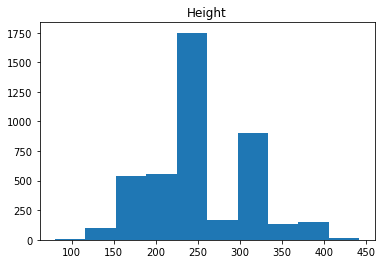

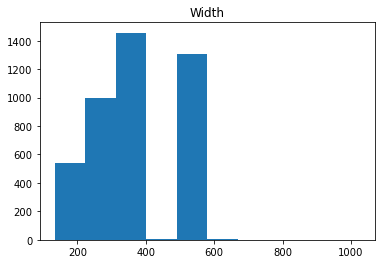

In [5]:
# To have a look at the distribution of image sizes
# Only run this if you have to, because it takes a few minutes (unless the dataset was loaded in memory)
all_sizes = [im.shape for im, _ in train_set] + [im.shape for im, _ in test_set]
plt.hist([x[0] for x in all_sizes])
plt.title('Height')
plt.show()
plt.hist([x[1] for x in all_sizes])
plt.title('Width')
plt.show()

(213, 320, 3)


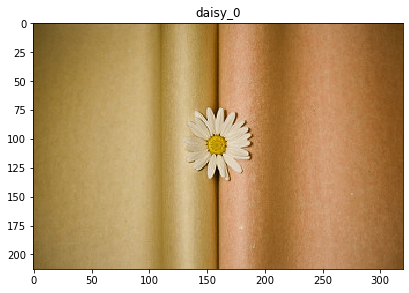

In [6]:
# Display an example image
im, label = train_set[0]
print(im.shape)
io.imshow(im)
plt.title(idx2lbl[label] + '_' + str(label))
plt.show()

In [7]:
class CNNClassifier(nn.Module):
    """
        The CNN architecture found to perform the best.
        Different hyperparameters were modified during our experiments:
        kernel size, number of convolutional and fully connected layers, number of feature maps,
        presence and type of padding, size of fully connected layers, presence or not of dropout and batch normalization.
    """
    def __init__(self, num_classes=5, padding="valid"):
        super(CNNClassifier, self).__init__()
        
        self.cnn_layer1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=padding),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.BatchNorm2d(16),
                                        nn.MaxPool2d(kernel_size=2))
        self.cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, padding=padding),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.BatchNorm2d(32),
                                        nn.MaxPool2d(kernel_size=2))
        self.cnn_layer3 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=padding),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.BatchNorm2d(64))
        
                                        
        self.linear_layer1 = nn.Linear(64, 32)
        self.dropout1 = nn.Dropout(0.3)
        self.activ1 = nn.ReLU()
        self.linear_layer2 = nn.Linear(32, 16)
        self.dropout2 = nn.Dropout(0.3)
        self.activ2 = nn.ReLU()
        self.linear_layer3 = nn.Linear(16, num_classes)
        
    def forward(self, images):

        images = torch.permute(images, [0, 3, 1, 2]) # The dimensions are initally messed up
        images = images.type(torch.FloatTensor) # And the type as well
        images = images.to(device)
        
        # Convolutions
        cnn1 = self.cnn_layer1(images)
        cnn2 = self.cnn_layer2(cnn1)
        cnn3 = self.cnn_layer3(cnn2)
        out_p = F.adaptive_max_pool2d(cnn3, output_size=1) # Global max pooling to have a fixed size output (1 element per feature map)
        out_vec = out_p.reshape(out_p.shape[0], -1)
        
        # Fully-connected layers
        out = self.linear_layer1(out_vec)
        out = self.activ1(out)
        #out = self.dropout1(out)
        out2 = self.linear_layer2(out)
        out2 = self.activ2(out2)
        out3 = self.linear_layer3(out2)
        return out3

In [8]:
def add_noise(inputs, noise_factor=0.3):
    """
        Noise-generating function for noise-aware training. We did not use it in practice.
    """
    noisy = inputs + torch.randn_like(inputs) * noise_factor
    noisy = torch.clip(noisy, 0., 1.)
    return noisy

In [9]:
def eval_cnn_classifier(model, eval_dataloader):
    """
        Evaluation function. Returns the model's accuracy out of 100
    """
    model.eval()
    model.to(device)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in eval_dataloader:
            labels = labels.to(device)
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


def training_cnn_classifier(model, train_dataloader, optimizer, num_epochs, loss_fn, learning_rate, verbose=True):
    """
        Training function with configurable optimizer. Returns the trained model along with the loss and test sec
        accuracy for all epochs.
    """
    model_tr = copy.deepcopy(model)
    model_tr.train()
    model_tr.to(device)
    
    best_model = copy.deepcopy(model_tr)
    best_acc = 0
    
    optimizer = optimizer(model_tr.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min') # Learning rate scheduler for optimizing convergence
    loss_all_epochs = []
    test_acc_all_epochs = []

    if verbose:
        print(f'Epoch [0/{num_epochs}], Loss: N/A, Test acc: {eval_cnn_classifier(model_tr, test_dataloader):.4f}%')
    total = len(train_dataloader)
    for epoch in range(num_epochs):
        loss_current_epoch = 0
        for images, labels in tqdm(train_dataloader, total=total):
            labels = labels.to(device)
            y_predicted = model_tr(images)
            loss = loss_fn(y_predicted, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_current_epoch += loss.item()
        
        loss_all_epochs.append(loss_current_epoch)
        test_acc = eval_cnn_classifier(model_tr, test_dataloader)
        if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model_tr)
        test_acc_all_epochs.append(test_acc)
        if verbose:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_current_epoch / total:.4f}, Test acc: {test_acc:.4f}%')
        
    return best_model, loss_all_epochs, test_acc_all_epochs

## Training

Total number of parameters:  26501
Epoch [0/20], Loss: N/A, Test acc: 13.5632%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:23<00:00, 46.62it/s]


Epoch [1/20], Loss: 1.2181, Test acc: 62.2989%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:21<00:00, 47.44it/s]


Epoch [2/20], Loss: 0.9636, Test acc: 64.5977%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:21<00:00, 47.43it/s]


Epoch [3/20], Loss: 0.8660, Test acc: 65.9770%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:20<00:00, 47.95it/s]


Epoch [4/20], Loss: 0.7815, Test acc: 63.9080%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:20<00:00, 48.05it/s]


Epoch [5/20], Loss: 0.7260, Test acc: 71.4943%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:24<00:00, 46.01it/s]


Epoch [6/20], Loss: 0.6793, Test acc: 72.6437%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:22<00:00, 47.21it/s]


Epoch [7/20], Loss: 0.6332, Test acc: 72.8736%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:21<00:00, 47.76it/s]


Epoch [8/20], Loss: 0.5927, Test acc: 72.8736%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:26<00:00, 44.95it/s]


Epoch [9/20], Loss: 0.5600, Test acc: 75.1724%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:22<00:00, 47.25it/s]


Epoch [10/20], Loss: 0.5404, Test acc: 75.1724%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:21<00:00, 47.72it/s]


Epoch [11/20], Loss: 0.4968, Test acc: 73.5632%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:21<00:00, 47.36it/s]


Epoch [12/20], Loss: 0.4794, Test acc: 75.1724%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:21<00:00, 47.83it/s]


Epoch [13/20], Loss: 0.4489, Test acc: 73.3333%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:21<00:00, 47.57it/s]


Epoch [14/20], Loss: 0.4318, Test acc: 77.2414%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:21<00:00, 47.37it/s]


Epoch [15/20], Loss: 0.4042, Test acc: 74.4828%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:21<00:00, 47.67it/s]


Epoch [16/20], Loss: 0.3793, Test acc: 74.2529%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:22<00:00, 47.25it/s]


Epoch [17/20], Loss: 0.3579, Test acc: 77.2414%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:21<00:00, 47.57it/s]


Epoch [18/20], Loss: 0.3539, Test acc: 77.2414%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:22<00:00, 47.30it/s]


Epoch [19/20], Loss: 0.3296, Test acc: 78.3908%


100%|███████████████████████████████████████████████████████████████████████████████| 3882/3882 [01:22<00:00, 47.22it/s]


Epoch [20/20], Loss: 0.3288, Test acc: 77.2414%


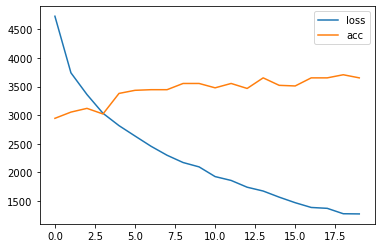

In [10]:
num_classes = 5
model = CNNClassifier(num_classes)

print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))
torch.manual_seed(0)
model.apply(init_weights)

num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam
learning_rate = 0.001 # Default value for Adam
batch_size = 1

train_dataloader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=batch_size)

model, loss_total, test_acc_total = training_cnn_classifier(model, train_dataloader, optimizer, num_epochs, loss_fn, learning_rate, verbose=True)

plt.plot(loss_total, label='loss')
plt.plot([max(loss_total)*x/100 for x in test_acc_total], label='acc')
plt.legend()
plt.show()

In [11]:
torch.save(model, 'best-model.pt')

## Evaluation

In [12]:
acc = eval_cnn_classifier(model, test_dataloader)
print(acc)

78.39080459770115


              precision    recall  f1-score   support

       daisy     0.7000    0.9091    0.7910        77
   dandelion     0.8073    0.8302    0.8186       106
        rose     0.8036    0.5696    0.6667        79
   sunflower     0.8841    0.8243    0.8531        74
       tulip     0.7624    0.7778    0.7700        99

    accuracy                         0.7839       435
   macro avg     0.7915    0.7822    0.7799       435
weighted avg     0.7905    0.7839    0.7809       435



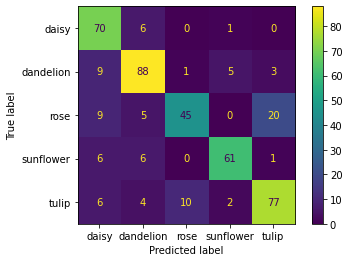

In [13]:
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        y_predicted = model(images)
        _, label_predicted = torch.max(y_predicted.data, 1)
        y_pred.append(label_predicted.item())
        y_true.append(labels.item())


target_names = idx2lbl
print(classification_report(y_true, y_pred, zero_division=0, digits=4, target_names=target_names))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot()

## Display (some) incorrectly classified images

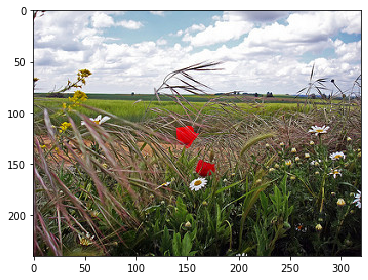

File: daisy/2607132536_d95198e619_n.jpg
Probabilities:
daisy      0.131 <-- true
dandelion  0.011
rose       0.661 <-- predicted
sunflower  0.011
tulip      0.187
----



/tmp/ipykernel_2326/513030097.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probas = softmax(y_predicted.data[0]).tolist()


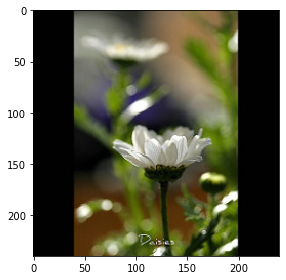

File: daisy/4434592930_6610d51fca_m.jpg
Probabilities:
daisy      0.112 <-- true
dandelion  0.710 <-- predicted
rose       0.042
sunflower  0.094
tulip      0.042
----



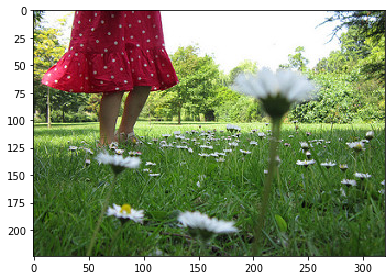

File: daisy/10391248763_1d16681106_n.jpg
Probabilities:
daisy      0.124 <-- true
dandelion  0.017
rose       0.622 <-- predicted
sunflower  0.016
tulip      0.220
----



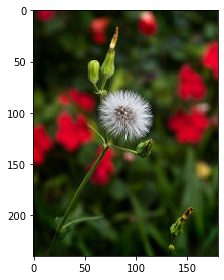

File: dandelion/6495802659_98b57e0cca_m.jpg
Probabilities:
daisy      0.041
dandelion  0.305 <-- true
rose       0.124
sunflower  0.002
tulip      0.529 <-- predicted
----



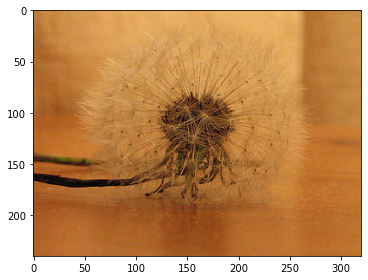

File: dandelion/253622055_d72964a7fd_n.jpg
Probabilities:
daisy      0.061
dandelion  0.141 <-- true
rose       0.438 <-- predicted
sunflower  0.071
tulip      0.289
----



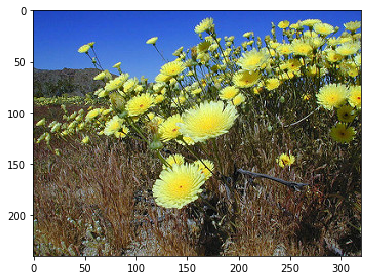

File: dandelion/8223949_2928d3f6f6_n.jpg
Probabilities:
daisy      0.798 <-- predicted
dandelion  0.198 <-- true
rose       0.001
sunflower  0.002
tulip      0.001
----



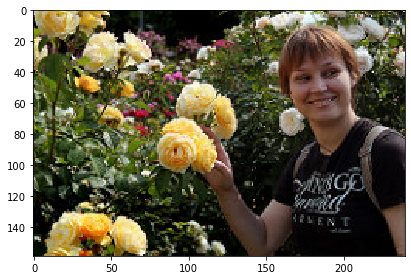

File: rose/7456439188_c2ba954a5d_n.jpg
Probabilities:
daisy      0.075
dandelion  0.012
rose       0.412 <-- true
sunflower  0.018
tulip      0.484 <-- predicted
----



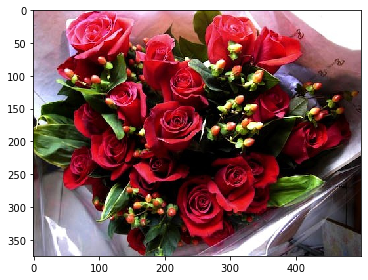

File: rose/2607130050_9c34310004.jpg
Probabilities:
daisy      0.004
dandelion  0.000
rose       0.248 <-- true
sunflower  0.001
tulip      0.747 <-- predicted
----



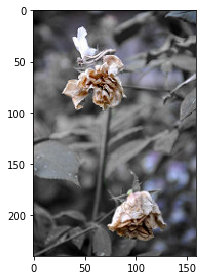

File: rose/5002446424_b86e3c646f_n.jpg
Probabilities:
daisy      0.585 <-- predicted
dandelion  0.297
rose       0.048 <-- true
sunflower  0.025
tulip      0.045
----



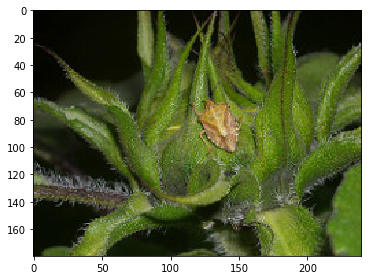

File: sunflower/3889694330_6f84d123d5_n.jpg
Probabilities:
daisy      0.095
dandelion  0.668 <-- predicted
rose       0.018
sunflower  0.119 <-- true
tulip      0.101
----



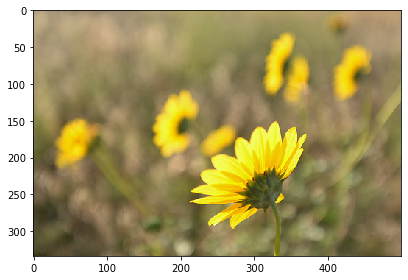

File: sunflower/20410533613_56da1cce7c.jpg
Probabilities:
daisy      0.048
dandelion  0.463 <-- predicted
rose       0.003
sunflower  0.411 <-- true
tulip      0.075
----



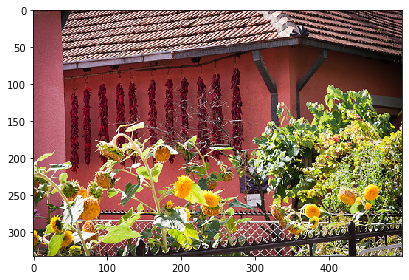

File: sunflower/5492906452_80943bfd04.jpg
Probabilities:
daisy      0.707 <-- predicted
dandelion  0.234
rose       0.001
sunflower  0.057 <-- true
tulip      0.002
----



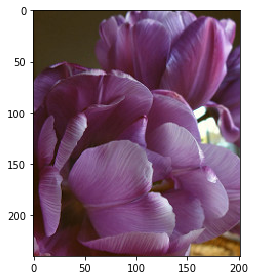

File: tulip/14026857634_500d7b41d6_m.jpg
Probabilities:
daisy      0.025
dandelion  0.006
rose       0.591 <-- predicted
sunflower  0.003
tulip      0.375 <-- true
----



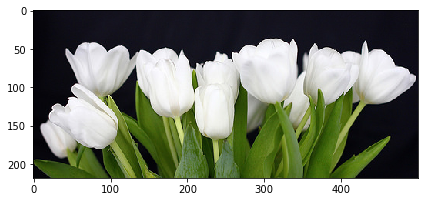

File: tulip/16506668270_b823935dc3.jpg
Probabilities:
daisy      0.036
dandelion  0.002
rose       0.540 <-- predicted
sunflower  0.011
tulip      0.411 <-- true
----



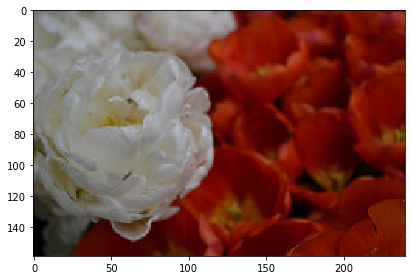

File: tulip/7166552648_28b6dce578_n.jpg
Probabilities:
daisy      0.117
dandelion  0.036
rose       0.588 <-- predicted
sunflower  0.035
tulip      0.224 <-- true
----



In [14]:
with torch.no_grad():
    softmax = nn.Softmax()
    for folder in folders:
        cnt = 0
        for file in folder:
            image = io.imread(data_dir + '/' + file)
            save_img = io.imread(data_dir + '/' + file)
            label = file.split('/')[0]
            image = (image - image.min())/(image.max() - image.min()) # Normalization
            image, label = image, lbl2idx[label]
            image = torch.FloatTensor(image).unsqueeze(0)
            y_predicted = model(image)
            _, label_predicted = torch.max(y_predicted.data, 1)
            if label_predicted != label:
                cnt += 1
                image = torch.permute(image, [0, 2, 1, 3])
                image = image.squeeze()
                io.imshow(save_img)
                plt.show()
                
                probas = softmax(y_predicted.data[0]).tolist()

                print('File:', file)
                print('Probabilities:')
                for i, p in enumerate(probas):
                    print(f'{idx2lbl[i]:<10} {p:.3f}', end='')
                    if i == label_predicted.item():
                        print(' <-- predicted', end='')
                    elif i == label:
                        print(' <-- true', end='')
                    print()
                print('----')
                print()
            if cnt >= 3:
                break

## Analysis

We can see that the model achieves a peak accuracy close to 80%, before dropping (overfitting?). Overall, the model performs well given the diversity of the dataset. Furthermore, even when wrong, the second highest probability is typically the one associated with the correct category.

It is possible that the model is constrained by its current architecture, notably due to the bottleneck of performing max pooling over the entire image before the dense layers, as well as the limited dataset size. However, we believe that it is not possible to reach a perfect accuracy - notably because some images in the dataset were found to not contain any flowers at all.

As mentioned before, it would be interesting to try other ways of dealing with different image sizes to see if those perform better.